In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap

# from ipywidgets import *

from typing import Union

import numpy as np
import pandas as pd
import pickle
import joblib
import datetime as dt
import time
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy.linalg import expm, logm
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wishart
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn import neighbors, clone


from pyfrechet.metric_spaces import MetricData, Euclidean, LogCholesky, spd_to_log_chol, log_chol_to_spd
# from pyfrechet.regression.frechet_regression import LocalFrechet, GlobalFrechet
# from pyfrechet.regression.kernels import NadarayaWatson, gaussian, epanechnikov
# from pyfrechet.regression.knn import KNearestNeighbours
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

INFO: Using numpy backend


# Data preparation

In [9]:
weather_data_jan=pd.read_excel('NY Weather Data.xlsx', sheet_name='January 2019 NY', skiprows=1)
weather_data_feb=pd.read_excel('NY Weather Data.xlsx', sheet_name='February 2019 NY', skiprows=1)

weather_colnames=['Day', 'Temp.Max', 'Temp.Avg', 'Temp.Min', 'DewPoint.Max', 'DewPoint.Avg', 'DewPoint.Min', 
                  'Humidity.Max', 'Humidity.Avg', 'Humidity.Min', 'WindSpeed.Max', 'WindSpeed.Avg', 'WindSpeed.Min',
                  'Pressure.Max', 'Pressure.Avg', 'Pressure.Min', 'Precipitation']

weather_data_jan.columns=weather_colnames
weather_data_feb.columns=weather_colnames

print(weather_data_jan.shape)
print(weather_data_feb.shape)
print(weather_data_jan.isna().sum().sum())
print(weather_data_feb.isna().sum().sum())

(31, 17)
(28, 17)
0
0


In [10]:
weather_data_jan.head()

,Day,Temp.Max,Temp.Avg,Temp.Min,DewPoint.Max,DewPoint.Avg,DewPoint.Min,Humidity.Max,Humidity.Avg,Humidity.Min,WindSpeed.Max,WindSpeed.Avg,WindSpeed.Min,Pressure.Max,Pressure.Avg,Pressure.Min,Precipitation
0,1,16,10.6,5,12,5.6,-3,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
1,2,5,3.0,2,-2,-5.3,-6,62,54.9,50,24,13.7,6,1027.4,1023.8,1018.2,0.00
2,3,7,5.5,4,3,-0.9,-6,86,64.7,45,33,16.7,0,1017.2,1013.4,1010.8,0.00
3,4,8,5.8,3,3,-1.7,-5,71,59.1,50,28,15.8,6,1015.9,1012.9,1007.1,0.00
4,5,8,6.7,6,6,4.7,1,96,88.2,68,33,21.9,9,1006.1,1000.1,994.5,5.84


In [11]:
taxi_zones=pd.read_csv('taxi+_zone_lookup.csv')
# list(taxi_zones[taxi_zones.Borough=='Manhattan'].Zone)
taxi_zones[taxi_zones.Borough=='Manhattan'][['Zone']]

,Zone
3,Alphabet City
11,Battery Park
12,Battery Park City
23,Bloomingdale
40,Central Harlem
...,...
245,West Chelsea/Hudson Yards
248,West Village
260,World Trade Center
261,Yorkville East


In [12]:
# Aggregate the different zones of Manhattan in the 10 groups
zones_correspondence={
    1: ['Central Harlem', 'Central Harlem North', 'Central Park', 'East Harlem North', 'East Harlem South',
        'Hamilton Heights', 'Inwood', 'Inwood Hill Park', 'Washington Heights North', 'Washington Heights South'],
    2: ['Bloomingdale', 'Manhattan Valley', 'Manhattanville', 'Morningside Heights', 'Upper West Side North', 
        'Upper West Side South'],
    3: ['Lenox Hill East', 'Lenox Hill West', 'Upper East Side North', 'Upper East Side South', 'Yorkville East',
        'Yorkville West'],
    4: ['Clinton East', 'Clinton West', 'East Chelsea', 'Lincoln Square East', 'Lincoln Square West', 'West Chelsea/Hudson Yards'],
    5: ['Garment District', 'Penn Station/Madison Sq West'],
    6: ['Midtown Center' ,'Midtown East', 'Midtown North', 'Times Sq/Theatre District'],
    7: ['Flatiron', 'Midtown South'],
    8: ['Gramercy', 'Kips Bay', 'Murray Hill', 'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North',
        'UN/Turtle Bay South', 'Union Sq'],
    9: ['Battery Park', 'Battery Park City', 'China Town', 'Greenwich Village North', 'Greenwich Village South',
        'Hudson Sq', 'Little Italy/NoLiTa', 'Meatpacking/West Village West', 'Seaport', 'SoHo', 'TriBeCa/Civic Center',
        'West Village', 'World Trade Center'],
    10: ['Alphabet City', 'East Village', 'Financial District North', 'Financial District South',
         'Lower East Side', 'Two Bridges/Seward Park']
}

not_manhattan=["Governor's Island/Ellis Island/Liberty Island",
               "Highbridge Park", "Marble Hill", "Randalls Island",
               "Roosevelt Island"]

In [13]:
zones_correspondence_ids={
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
}

for index, zone in taxi_zones[taxi_zones.Borough=='Manhattan'][['Zone']].iterrows():
    for key in zones_correspondence.keys():
        if zone['Zone'] in zones_correspondence[key]:
            zones_correspondence_ids[key].append(index+1)

zones_correspondence_ids

{1: [41, 42, 43, 74, 75, 116, 127, 128, 243, 244],
 2: [24, 151, 152, 166, 238, 239],
 3: [140, 141, 236, 237, 262, 263],
 4: [48, 50, 68, 142, 143, 246],
 5: [100, 186],
 6: [161, 162, 163, 230],
 7: [90, 164],
 8: [107, 137, 170, 224, 229, 233, 234],
 9: [12, 13, 113, 114, 125, 144, 158, 209, 211, 231, 249, 261],
 10: [4, 79, 87, 88, 148, 232]}

In [14]:
zones_correspondence_ids_1to1={}

for (key, value) in zones_correspondence_ids.items():
    for ID in value:
        zones_correspondence_ids_1to1[ID]=key

In [15]:
taxi_data_jan=pd.read_csv('yellow_tripdata_2019-01.csv')
taxi_data_feb=pd.read_csv('yellow_tripdata_2019-02.csv')

taxi_data_jan.drop(columns=['congestion_surcharge', 'VendorID', 'store_and_fwd_flag', 
                            'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'RatecodeID'], inplace=True)
taxi_data_feb.drop(columns=['congestion_surcharge', 'VendorID', 'store_and_fwd_flag', 
                            'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'RatecodeID'], inplace=True)


In [16]:
print(taxi_data_jan.isna().sum().sum())
print(taxi_data_feb.isna().sum().sum())
print(taxi_data_jan.info())

0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667792 entries, 0 to 7667791
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   passenger_count        int64  
 3   trip_distance          float64
 4   PULocationID           int64  
 5   DOLocationID           int64  
 6   payment_type           int64  
 7   fare_amount            float64
 8   tip_amount             float64
 9   total_amount           float64
dtypes: float64(4), int64(4), object(2)
memory usage: 585.0+ MB
None


In [17]:
zones_to_keep=[]
for value in zones_correspondence_ids.values():
    zones_to_keep+=value

taxi_data_jan_manh=taxi_data_jan[(taxi_data_jan.PULocationID.isin(zones_to_keep)) & (taxi_data_jan.DOLocationID.isin(zones_to_keep))]
taxi_data_feb_manh=taxi_data_feb[(taxi_data_feb.PULocationID.isin(zones_to_keep)) & (taxi_data_feb.DOLocationID.isin(zones_to_keep))]

del taxi_data_jan
del taxi_data_feb

taxi_data_jan_manh['tpep_pickup_datetime']=pd.to_datetime(taxi_data_jan_manh['tpep_pickup_datetime'])
taxi_data_jan_manh['tpep_dropoff_datetime']=pd.to_datetime(taxi_data_jan_manh['tpep_dropoff_datetime'])
taxi_data_feb_manh['tpep_pickup_datetime']=pd.to_datetime(taxi_data_feb_manh['tpep_pickup_datetime'])
taxi_data_feb_manh['tpep_dropoff_datetime']=pd.to_datetime(taxi_data_feb_manh['tpep_dropoff_datetime'])

In [18]:
PUZone_jan=[]
DOZone_jan=[]
PUZone_feb=[]
DOZone_feb=[]

for zone in taxi_data_jan_manh['PULocationID']:
    PUZone_jan.append(zones_correspondence_ids_1to1[zone])

for zone in taxi_data_jan_manh['DOLocationID']:
    DOZone_jan.append(zones_correspondence_ids_1to1[zone])

for zone in taxi_data_feb_manh['PULocationID']:
    PUZone_feb.append(zones_correspondence_ids_1to1[zone])

for zone in taxi_data_feb_manh['DOLocationID']:
    DOZone_feb.append(zones_correspondence_ids_1to1[zone])

taxi_data_jan_manh['PULocationZone']=PUZone_jan
taxi_data_jan_manh['DOLocationZone']=DOZone_jan
taxi_data_feb_manh['PULocationZone']=PUZone_feb
taxi_data_feb_manh['DOLocationZone']=DOZone_feb

del PUZone_jan, DOZone_jan, PUZone_feb, DOZone_feb

In [22]:
taxi_data_jan_manh.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,PULocationZone,DOLocationZone
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,151,239,1,7.0,1.65,9.95,2,2
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,239,246,1,14.0,1.00,16.30,2,4
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,236,236,1,4.5,0.00,5.80,3,3
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,163,229,1,6.5,1.25,9.05,6,8
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,141,234,1,10.0,1.70,13.00,3,8


In [20]:
taxi_data_jan_manh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6467338 entries, 0 to 7667787
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
 6   payment_type           int64         
 7   fare_amount            float64       
 8   tip_amount             float64       
 9   total_amount           float64       
 10  PULocationZone         int64         
 11  DOLocationZone         int64         
dtypes: datetime64[ns](2), float64(4), int64(6)
memory usage: 641.4 MB


In [21]:
def create_adjacency(df: pd.DataFrame, zones_correspondence_ids: dict) -> np.ndarray:
    mat=np.zeros((len(zones_correspondence_ids.keys()), len(zones_correspondence_ids.keys())))
    for i in range(df.shape[0]):
        PUzone=df.iloc[i]['PULocationZone']-1
        DOzone=df.iloc[i]['DOLocationZone']-1
        mat[PUzone, DOzone]+=1
        mat[DOzone, PUzone]+=1
    return mat


In [55]:
# Some tests
date=pd.date_range(start='2019-01-01', end='2019-02-01', freq='H')[0]
daily_df=taxi_data_jan_manh[(taxi_data_jan_manh.tpep_pickup_datetime>date) & (taxi_data_jan_manh.tpep_pickup_datetime<date+timedelta(hours=1))]
print(create_adjacency(daily_df, zones_correspondence_ids))


[[ 402.  220.  277.  126.   15.  110.   23.  110.   58.   45.]
 [ 220.  676.  323.  461.    9.   89.   25.  121.   97.   41.]
 [ 277.  323. 1544.  296.   36.  289.   71.  580.  209.  139.]
 [ 126.  461.  296. 1000.  105.  193.  167.  383.  423.  197.]
 [  15.    9.   36.  105.   28.   45.   46.  100.   62.   49.]
 [ 110.   89.  289.  193.   45.  286.   84.  347.  124.   91.]
 [  23.   25.   71.  167.   46.   84.   60.  264.  191.  149.]
 [ 110.  121.  580.  383.  100.  347.  264.  908.  452.  459.]
 [  58.   97.  209.  423.   62.  124.  191.  452.  864.  458.]
 [  45.   41.  139.  197.   49.   91.  149.  459.  458.  486.]]


In [25]:
taxi_data_jan_manh_aggregate=pd.DataFrame()
taxi_data_jan_manh_aggregate_Y=[]

for date in tqdm(pd.date_range(start='2019-01-01', end='2019-01-31 23:00:00', freq='h'), desc='Progress'):
    daily_df=taxi_data_jan_manh[(taxi_data_jan_manh.tpep_pickup_datetime>date) & (taxi_data_jan_manh.tpep_pickup_datetime<=date+timedelta(hours=1))]
    
    # Deprecated
    # taxi_data_jan_manh_aggregate.append({'tpep_pickup_datetime': date,
    #                                     'tpep_dropoff_datetime': date+timedelta(hours=1),
    #                                     'passenger_count': daily_df['passenger_count'].mean(),
    #                                     'trip_distance': daily_df['trip_distance'].mean(),
    #                                     'adjacency': create_adjacency(daily_df, zones_correspondence_ids)
    #                                     }, ignore_index=True)
    
    taxi_data_jan_manh_aggregate=pd.concat([taxi_data_jan_manh_aggregate, 
                                            pd.DataFrame({'hour_interval_lower': date,
                                                        'hour_interval_upper': date+timedelta(hours=1),
                                                        'passenger_count': daily_df['passenger_count'].mean(),
                                                        'trip_distance': daily_df['trip_distance'].mean(),
                                                        'fare_amount': daily_df['fare_amount'].mean(),
                                                        'tip_amount': daily_df['tip_amount'].mean(),
                                                        'total_amount': daily_df['total_amount'].mean()
                                            }, index=[0])], ignore_index=True)

    taxi_data_jan_manh_aggregate_Y.append(create_adjacency(daily_df, zones_correspondence_ids))

with open('taxi_data_jan_Y.pkl', 'wb') as f:
    pickle.dump(taxi_data_jan_manh_aggregate_Y, f)

Progress: 100%|██████████| 744/744 [24:58<00:00,  2.01s/it]


In [46]:
pd.date_range(start='2019-01-01', end='2019-01-31 23:00:00', freq='H')

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-01-31 14:00:00', '2019-01-31 15:00:00',
               '2019-01-31 16:00:00', '2019-01-31 17:00:00',
               '2019-01-31 18:00:00', '2019-01-31 19:00:00',
               '2019-01-31 20:00:00', '2019-01-31 21:00:00',
               '2019-01-31 22:00:00', '2019-01-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq='H')

In [26]:
print(taxi_data_jan_manh_aggregate.describe())
print(taxi_data_jan_manh_aggregate.tail())

       hour_interval_lower  hour_interval_upper  passenger_count  \
count                  744                  744       744.000000   
mean   2019-01-16 11:30:00  2019-01-16 12:30:00         1.574364   
min    2019-01-01 00:00:00  2019-01-01 01:00:00         1.395867   
25%    2019-01-08 17:45:00  2019-01-08 18:45:00         1.523699   
50%    2019-01-16 11:30:00  2019-01-16 12:30:00         1.567714   
75%    2019-01-24 05:15:00  2019-01-24 06:15:00         1.626490   
max    2019-01-31 23:00:00  2019-02-01 00:00:00         1.758446   
std                    NaN                  NaN         0.066214   

       trip_distance  fare_amount  tip_amount  total_amount  
count     744.000000   744.000000  744.000000    744.000000  
mean        1.840567     9.222568    1.369781     11.721517  
min         1.539820     7.509535    0.891886      9.526859  
25%         1.673708     8.884560    1.232795     11.190274  
50%         1.758784     9.221794    1.396119     11.811418  
75%         2.0

In [27]:
print(taxi_data_jan_manh_aggregate_Y[-1])

[[122. 102. 116. 137.  20.  96.  35.  60.  42.  27.]
 [102. 336.  89. 210.  31. 111.  21.  58.  47.  18.]
 [116.  89. 570. 210. 113. 229. 105. 266. 111.  74.]
 [137. 210. 210. 648. 149. 391. 122. 285. 289. 111.]
 [ 20.  31. 113. 149.  44. 184.  48. 228. 129.  64.]
 [ 96. 111. 229. 391. 184. 370. 125. 367. 198. 129.]
 [ 35.  21. 105. 122.  48. 125.  70. 238. 187. 105.]
 [ 60.  58. 266. 285. 228. 367. 238. 684. 360. 280.]
 [ 42.  47. 111. 289. 129. 198. 187. 360. 780. 376.]
 [ 27.  18.  74. 111.  64. 129. 105. 280. 376. 366.]]


In [28]:
taxi_data_feb_manh_aggregate=pd.DataFrame()
taxi_data_feb_manh_aggregate_Y=[]

for date in tqdm(pd.date_range(start='2019-02-01', end='2019-02-28 23:00:00', freq='h'), desc='Progress'):
    daily_df=taxi_data_feb_manh[(taxi_data_feb_manh.tpep_pickup_datetime>date) & (taxi_data_feb_manh.tpep_pickup_datetime<=date+timedelta(hours=1))]
    
    # Deprecated
    # taxi_data_feb_manh_aggregate.append({'tpep_pickup_datetime': date,
    #                                     'tpep_dropoff_datetime': date+timedelta(hours=1),
    #                                     'passenger_count': daily_df['passenger_count'].mean(),
    #                                     'trip_distance': daily_df['trip_distance'].mean(),
    #                                     'adjacency': create_adjacency(daily_df, zones_correspondence_ids)
    #                                     }, ignore_index=True)
    
    taxi_data_feb_manh_aggregate=pd.concat([taxi_data_feb_manh_aggregate, 
                                            pd.DataFrame({'hour_interval_lower': date,
                                                        'hour_interval_upper': date+timedelta(hours=1),
                                                        'passenger_count': daily_df['passenger_count'].mean(),
                                                        'trip_distance': daily_df['trip_distance'].mean(),
                                                        'fare_amount': daily_df['fare_amount'].mean(),
                                                        'tip_amount': daily_df['tip_amount'].mean(),
                                                        'total_amount': daily_df['total_amount'].mean()
                                            }, index=[0])], ignore_index=True)

    taxi_data_feb_manh_aggregate_Y.append(create_adjacency(daily_df, zones_correspondence_ids))

with open('taxi_data_feb_Y.pkl', 'wb') as f:
    pickle.dump(taxi_data_feb_manh_aggregate_Y, f)

Progress: 100%|██████████| 672/672 [21:48<00:00,  1.95s/it]


In [29]:
with open('taxi_data_jan_tripdata.pkl', 'wb') as f:
    pickle.dump(taxi_data_jan_manh_aggregate, f)

with open('taxi_data_feb_tripdata.pkl', 'wb') as f:
    pickle.dump(taxi_data_feb_manh_aggregate, f)

## Join trips data with meteorological data

Firstly,  we have the aggregated trip data by hour:

In [30]:
with open('taxi_data_jan_tripdata.pkl', 'rb') as f:
    taxi_data_jan = pickle.load(f)

with open('taxi_data_feb_tripdata.pkl', 'rb') as f:
    taxi_data_feb = pickle.load(f)

print(taxi_data_jan.info())
print(taxi_data_feb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hour_interval_lower  744 non-null    datetime64[ns]
 1   hour_interval_upper  744 non-null    datetime64[ns]
 2   passenger_count      744 non-null    float64       
 3   trip_distance        744 non-null    float64       
 4   fare_amount          744 non-null    float64       
 5   tip_amount           744 non-null    float64       
 6   total_amount         744 non-null    float64       
dtypes: datetime64[ns](2), float64(5)
memory usage: 40.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hour_interval_lower  672 non-null    datetime64[ns]
 1   hour_interval_upper  672 non-null    d

Secondly, the meteorological data by day:

In [31]:
print(weather_data_jan.shape)
print(weather_data_feb.shape)
print(weather_data_jan.info())
# print(weather_data_feb.info())

(31, 17)
(28, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Day            31 non-null     int64  
 1   Temp.Max       31 non-null     int64  
 2   Temp.Avg       31 non-null     float64
 3   Temp.Min       31 non-null     int64  
 4   DewPoint.Max   31 non-null     int64  
 5   DewPoint.Avg   31 non-null     float64
 6   DewPoint.Min   31 non-null     int64  
 7   Humidity.Max   31 non-null     int64  
 8   Humidity.Avg   31 non-null     float64
 9   Humidity.Min   31 non-null     int64  
 10  WindSpeed.Max  31 non-null     int64  
 11  WindSpeed.Avg  31 non-null     float64
 12  WindSpeed.Min  31 non-null     int64  
 13  Pressure.Max   31 non-null     float64
 14  Pressure.Avg   31 non-null     float64
 15  Pressure.Min   31 non-null     float64
 16  Precipitation  31 non-null     float64
dtypes: float64(8), int64(9)
memory usage: 

In [32]:
weather_data_jan_repeated=pd.DataFrame(columns=weather_data_jan.columns.to_list())
for i in range(weather_data_jan.shape[0]):
    weather_day=pd.concat([weather_data_jan.iloc[[i]]] * 24, ignore_index=True)
    weather_data_jan_repeated=pd.concat([weather_data_jan_repeated, weather_day], ignore_index=True)
    # print(weather_data_jan_repeated.shape)

# Join taxi data with meteorological one
taxi_data_jan_joined=pd.concat([taxi_data_jan, weather_data_jan_repeated], axis=1)

with open('taxi_data_jan_joined.pkl', 'wb') as f:
    pickle.dump(taxi_data_jan_joined, f)

C:\Users\J2404\AppData\Local\Temp\ipykernel_19404\518296240.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weather_data_jan_repeated=pd.concat([weather_data_jan_repeated, weather_day], ignore_index=True)


In [37]:
weather_data_feb_repeated=pd.DataFrame(columns=weather_data_feb.columns.to_list())
for i in range(weather_data_feb.shape[0]):
    weather_day=pd.concat([weather_data_feb.iloc[[i]]] * 24, ignore_index=True)
    weather_data_feb_repeated=pd.concat([weather_data_feb_repeated, weather_day], ignore_index=True)
    # print(weather_data_feb_repeated.shape)

# Join taxi data with meteorological one
taxi_data_feb_joined=pd.concat([taxi_data_feb, weather_data_feb_repeated], axis=1)

with open('taxi_data_feb_joined.pkl', 'wb') as f:
    pickle.dump(taxi_data_feb_joined, f)

C:\Users\J2404\AppData\Local\Temp\ipykernel_19404\2134300829.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weather_data_feb_repeated=pd.concat([weather_data_feb_repeated, weather_day], ignore_index=True)


In [38]:
taxi_data_feb_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hour_interval_lower  672 non-null    datetime64[ns]
 1   hour_interval_upper  672 non-null    datetime64[ns]
 2   passenger_count      672 non-null    float64       
 3   trip_distance        672 non-null    float64       
 4   fare_amount          672 non-null    float64       
 5   tip_amount           672 non-null    float64       
 6   total_amount         672 non-null    float64       
 7   Day                  672 non-null    object        
 8   Temp.Max             672 non-null    object        
 9   Temp.Avg             672 non-null    float64       
 10  Temp.Min             672 non-null    object        
 11  DewPoint.Max         672 non-null    object        
 12  DewPoint.Avg         672 non-null    float64       
 13  DewPoint.Min         672 non-null  

Let's add a column with the week day and an indicator with the rush hours:

In [39]:
with open('taxi_data_jan_joined.pkl', 'rb') as f:
    df_jan = pickle.load(f)

with open('taxi_data_feb_joined.pkl', 'rb') as f:
    df_feb = pickle.load(f)

In [40]:
df_jan

,hour_interval_lower,hour_interval_upper,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,Day,Temp.Max,Temp.Avg,...,Humidity.Max,Humidity.Avg,Humidity.Min,WindSpeed.Max,WindSpeed.Avg,WindSpeed.Min,Pressure.Max,Pressure.Avg,Pressure.Min,Precipitation
0,2019-01-01 00:00:00,2019-01-01 01:00:00,1.726331,2.148636,10.669542,1.567564,13.549008,1,16,10.6,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
1,2019-01-01 01:00:00,2019-01-01 02:00:00,1.722677,2.309549,10.774077,1.601065,13.693431,1,16,10.6,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
2,2019-01-01 02:00:00,2019-01-01 03:00:00,1.693085,2.349843,10.347396,1.596639,13.250192,1,16,10.6,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
3,2019-01-01 03:00:00,2019-01-01 04:00:00,1.670243,2.308220,9.928239,1.469787,12.699407,1,16,10.6,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
4,2019-01-01 04:00:00,2019-01-01 05:00:00,1.679593,2.458458,10.105830,1.402374,12.799580,1,16,10.6,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2019-01-31 19:00:00,2019-01-31 20:00:00,1.543949,1.687769,9.395804,1.674620,12.846879,31,-9,-11.9,...,46,36.1,29,31,23.4,15,1029.7,1027.7,1024.0,0.00
740,2019-01-31 20:00:00,2019-01-31 21:00:00,1.556198,1.869081,9.474702,1.657361,12.441544,31,-9,-11.9,...,46,36.1,29,31,23.4,15,1029.7,1027.7,1024.0,0.00
741,2019-01-31 21:00:00,2019-01-31 22:00:00,1.588293,2.022072,9.672523,1.689852,12.666425,31,-9,-11.9,...,46,36.1,29,31,23.4,15,1029.7,1027.7,1024.0,0.00
742,2019-01-31 22:00:00,2019-01-31 23:00:00,1.589095,2.079742,9.730825,1.733313,12.771960,31,-9,-11.9,...,46,36.1,29,31,23.4,15,1029.7,1027.7,1024.0,0.00


In [41]:
# Add the weekday
weekdays_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekdays_jan=[df_jan['hour_interval_lower'][i].weekday() for i in df_jan.index] # 0 for Monday, ..., 6 for Sunday
df_jan.insert(8, 'Weekday', [weekdays_names[i] for i in weekdays_jan])

weekdays_feb=[df_feb['hour_interval_lower'][i].weekday() for i in df_feb.index] # 0 for Monday, ..., 6 for Sunday
df_feb.insert(8, 'Weekday', [weekdays_names[i] for i in weekdays_feb])

In [42]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hour_interval_lower  744 non-null    datetime64[ns]
 1   hour_interval_upper  744 non-null    datetime64[ns]
 2   passenger_count      744 non-null    float64       
 3   trip_distance        744 non-null    float64       
 4   fare_amount          744 non-null    float64       
 5   tip_amount           744 non-null    float64       
 6   total_amount         744 non-null    float64       
 7   Day                  744 non-null    object        
 8   Weekday              744 non-null    object        
 9   Temp.Max             744 non-null    object        
 10  Temp.Avg             744 non-null    float64       
 11  Temp.Min             744 non-null    object        
 12  DewPoint.Max         744 non-null    object        
 13  DewPoint.Avg         744 non-null  

In [43]:
# According to https://new.mta.info/sites/default/files/2019-10/service_guide_web_Oct19.pdf 
# (Metropolitan Transportation Authority (MTA))
start_late_night=dt.time(hour=0, minute=0)
end_late_night=dt.time(hour=6, minute=0)
start_rush_hour1=dt.time(hour=6, minute=0)
end_rush_hour1=dt.time(hour=9, minute=0)
start_middays=dt.time(hour=9, minute=0)
end_middays=dt.time(hour=16, minute=0)
start_rush_hour2=dt.time(hour=16, minute=0)
end_rush_hour2=dt.time(hour=20, minute=0)
start_evening=dt.time(hour=20, minute=0)
end_evening=dt.time(hour=23, minute=59, second=59)

In [44]:
hour_indicator_jan=[]

for i in df_jan.index:
    indicator='RushHour'
    if start_late_night < (df_jan['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_late_night:
        indicator='LateNight'
    elif start_middays < (df_jan['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_middays:
        indicator='Middays'
    elif start_evening < (df_jan['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_evening:
        indicator='Evening'
    hour_indicator_jan.append(indicator)

df_jan.insert(9, 'Hour.Indicator', hour_indicator_jan)

with open('taxi_data_jan_joined.pkl', 'wb') as f:
    pickle.dump(df_jan, f)

In [45]:
hour_indicator_feb=[]

for i in df_feb.index:
    indicator='RushHour'
    if start_late_night < (df_feb['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_late_night:
        indicator='LateNight'
    elif start_middays < (df_feb['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_middays:
        indicator='Middays'
    elif start_evening < (df_feb['hour_interval_upper'][i]-timedelta(minutes=1)).time() <= end_evening:
        indicator='Evening'
    hour_indicator_feb.append(indicator)

df_feb.insert(9, 'Hour.Indicator', hour_indicator_feb)

with open('taxi_data_feb_joined.pkl', 'wb') as f:
    pickle.dump(df_feb, f)

In [46]:
df_feb.head()

,hour_interval_lower,hour_interval_upper,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,Day,Weekday,Hour.Indicator,...,Humidity.Max,Humidity.Avg,Humidity.Min,WindSpeed.Max,WindSpeed.Avg,WindSpeed.Min,Pressure.Max,Pressure.Avg,Pressure.Min,Precipitation
0,2019-02-01 00:00:00,2019-02-01 01:00:00,1.616164,2.071731,9.392273,1.572473,12.272360,1,Friday,LateNight,...,44,35.8,27,28,15.3,6,1031.1,1029.1,1027.0,0.0
1,2019-02-01 01:00:00,2019-02-01 02:00:00,1.657037,2.045280,8.939839,1.398962,11.633252,1,Friday,LateNight,...,44,35.8,27,28,15.3,6,1031.1,1029.1,1027.0,0.0
2,2019-02-01 02:00:00,2019-02-01 03:00:00,1.636463,2.091988,8.856068,1.305404,11.454470,1,Friday,LateNight,...,44,35.8,27,28,15.3,6,1031.1,1029.1,1027.0,0.0
3,2019-02-01 03:00:00,2019-02-01 04:00:00,1.677288,2.138056,9.105637,1.341593,11.735163,1,Friday,LateNight,...,44,35.8,27,28,15.3,6,1031.1,1029.1,1027.0,0.0
4,2019-02-01 04:00:00,2019-02-01 05:00:00,1.660075,2.025650,8.712335,1.072382,11.082420,1,Friday,LateNight,...,44,35.8,27,28,15.3,6,1031.1,1029.1,1027.0,0.0


# Modelling

In [2]:
with open('taxi_data_jan_joined.pkl', 'rb') as f:
    df_jan = pickle.load(f)

with open('taxi_data_feb_joined.pkl', 'rb') as f:
    df_feb = pickle.load(f)

In [3]:
with open('taxi_data_jan_Y.pkl', 'rb') as f:
    Y_jan=pickle.load(f)

with open('taxi_data_feb_Y.pkl', 'rb') as f:
    Y_feb=pickle.load(f)

In [4]:
Y= Y_jan + Y_feb
df=pd.concat([df_jan, df_feb], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hour_interval_lower  1416 non-null   datetime64[ns]
 1   hour_interval_upper  1416 non-null   datetime64[ns]
 2   passenger_count      1416 non-null   float64       
 3   trip_distance        1416 non-null   float64       
 4   fare_amount          1416 non-null   float64       
 5   tip_amount           1416 non-null   float64       
 6   total_amount         1416 non-null   float64       
 7   Day                  1416 non-null   object        
 8   Weekday              1416 non-null   object        
 9   Hour.Indicator       1416 non-null   object        
 10  Temp.Max             1416 non-null   object        
 11  Temp.Avg             1416 non-null   float64       
 12  Temp.Min             1416 non-null   object        
 13  DewPoint.Max         1416 non-nul

In [5]:
M=LogCholesky(dim=10)

# Without all the variables in Qui et al.
X=df[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
          'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday']]
# Including some variables from Qui et al. that are not realistic
# X=df[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
#           'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday', 'fare_amount', 
#           'tip_amount', 'total_amount', 'trip_distance', 'passenger_count']]
# Including only the non-realistic variables
# X=df[['Hour.Indicator', 'Weekday', 'fare_amount', 
#           'tip_amount', 'total_amount', 'trip_distance', 'passenger_count']]
X=pd.get_dummies(data=X, columns=['Hour.Indicator', 'Weekday'])
Y_stand=[A/A.max() for A in Y] # Standardize the weights
Y_ExpLogChol=np.c_[[spd_to_log_chol(expm(A)) for A in Y_stand]]
y=MetricData(M, Y_ExpLogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=283, random_state=100)
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [12]:
df.head()

,hour_interval_lower,hour_interval_upper,passenger_count,trip_distance,Day,Weekday,Hour.Indicator,Temp.Max,Temp.Avg,Temp.Min,...,Humidity.Max,Humidity.Avg,Humidity.Min,WindSpeed.Max,WindSpeed.Avg,WindSpeed.Min,Pressure.Max,Pressure.Avg,Pressure.Min,Precipitation
0,2019-01-01 00:00:00,2019-01-01 01:00:00,1.726331,2.148636,1,Tuesday,LateNight,16,10.6,5,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
1,2019-01-01 01:00:00,2019-01-01 02:00:00,1.722677,2.309549,1,Tuesday,LateNight,16,10.6,5,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
2,2019-01-01 02:00:00,2019-01-01 03:00:00,1.693085,2.349843,1,Tuesday,LateNight,16,10.6,5,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
3,2019-01-01 03:00:00,2019-01-01 04:00:00,1.670243,2.308220,1,Tuesday,LateNight,16,10.6,5,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31
4,2019-01-01 04:00:00,2019-01-01 05:00:00,1.679593,2.458458,1,Tuesday,LateNight,16,10.6,5,...,97,73.5,50,44,24.7,0,1021.0,1008.3,1001.3,35.31


In [12]:
type(y_train)

pyfrechet.metric_spaces.metric_data.MetricData

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temp.Avg                  744 non-null    float64
 1   DewPoint.Avg              744 non-null    float64
 2   Humidity.Avg              744 non-null    float64
 3   WindSpeed.Avg             744 non-null    float64
 4   Pressure.Avg              744 non-null    float64
 5   Precipitation             744 non-null    float64
 6   Hour.Indicator_Evening    744 non-null    bool   
 7   Hour.Indicator_LateNight  744 non-null    bool   
 8   Hour.Indicator_Middays    744 non-null    bool   
 9   Hour.Indicator_RushHour   744 non-null    bool   
 10  Weekday_Friday            744 non-null    bool   
 11  Weekday_Monday            744 non-null    bool   
 12  Weekday_Saturday          744 non-null    bool   
 13  Weekday_Sunday            744 non-null    bool   
 14  Weekday_Th

In [54]:
base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=4,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=3,
                         verbose=10)
forest.fit(X_train, y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   15.1s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   19.4s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   26.6s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   32.5s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   39.8s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   46.9s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:   56.6s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.6min finished


BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(impurity_method='medoid', mtry=4,
                               split_type='2means'),
                n_jobs=3, verbose=10)

In [55]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 0.7055558865335412
MSE: 0.6379813357971886


0.795774647887324

In [ ]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None,
                                         cmap='viridis'):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap=cmap)
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

matrices_to_plot=[]
for i in [1,8,15,21,100,101,120,150,170,200]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(5,4))

In [10]:
# Retrieve the actual predictions for the network (undo the exponential mapping)
# Predictions of y_test (forest_predictions) after undoing the exponential
Y_test_stand=[logm(log_chol_to_spd(A)) for A in y_test.data]
Y_test_stand_pred=[logm(log_chol_to_spd(A)) for A in forest_predictions.data]

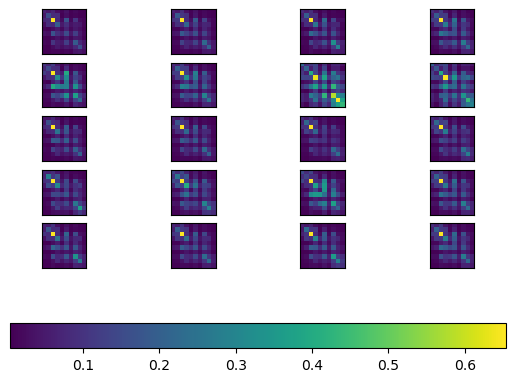

In [11]:
matrices_to_plot=[]
for i in [1,8,15,21,100,101,105,120,150,170]:
    matrices_to_plot.append(Y_test_stand[i])
    matrices_to_plot.append(Y_test_stand_pred[i])
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(5,4))

# Hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

## Without train-train and train-validation splitting:

In [44]:
M=LogCholesky(dim=10)

X=df[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
          'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday']]
X=pd.get_dummies(data=X, columns=['Hour.Indicator', 'Weekday'])
Y_stand=[A/A.max() for A in Y] # Standardize the weights
Y_ExpLogChol=np.c_[[spd_to_log_chol(expm(A)) for A in Y_stand]]
y=MetricData(M, Y_ExpLogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=283, random_state=100)
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

print(f'Train size: {X_train.shape} and {y_train.shape}')
print(f'Test size: {X_test.shape} and {y_test.shape}')

Train size: (1133, 17) and (1133,)
Test size: (283, 17) and (283,)


In [54]:
param_grid={
    'estimator__min_split_size': [1, 5, 10, 15, 20, 25, 30],
    'estimator__mtry': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14]
}

# In SearchGridCV we must use a score (greater the better) rather than a loss function (mse)
neg_mse=make_scorer(score_func=mse, 
                    greater_is_better=False,
                    sample_weight=None) # Since mse is a loss function, not a score function

# If cv is not specified, 5-CV is used by default
tuned_forest=GridSearchCV(
    estimator=BaggedRegressor(estimator=Tree(split_type='2means',
                                             impurity_method='medoid'),
                            n_estimators=100,
                            bootstrap_fraction=1,
                            bootstrap_replace=True),
    param_grid=param_grid,
    scoring=neg_mse,
    cv=3,
    n_jobs=6,
    verbose=30
)

start_time=time.time()
tuned_forest.fit(X_train, y_train)
end_time=time.time()
print(f'Tuning execution time: {end_time-start_time}')

Fitting 3 folds for each of 70 candidates, totalling 210 fits


KeyboardInterrupt: 

## With train-train and train-validation:

In [31]:
M=LogCholesky(dim=10)

X=df[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
          'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday']]
X=pd.get_dummies(data=X, columns=['Hour.Indicator', 'Weekday'])
Y_stand=[A/A.max() for A in Y] # Standardize the weights
Y_ExpLogChol=np.c_[[spd_to_log_chol(expm(A)) for A in Y_stand]]
y=MetricData(M, Y_ExpLogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=283, random_state=100)
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [34]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=283, random_state=200)
print(f'Train-Train size: {X_train_train.shape}')
print(f'Train-Validation size: {X_train_test.shape}')
print(f'Test size: {X_test.shape}')

Train-Train size: (850, 17)
Train-Validation size: (283, 17)
Test size: (283, 17)


In [92]:
param_grid={
    'estimator__min_split_size': [1, 5, 10, 15, 20, 25, 30],
    'estimator__mtry': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14]
}

# In SearchGridCV we must use a score (greater the better) rather than a loss function (mse)
neg_mse=make_scorer(score_func=mse, 
                    greater_is_better=False,
                    sample_weight=None) # Since mse is a loss function, not a score function

# If cv is not specified, 5-CV is used by default
tuned_forest=GridSearchCV(
    estimator=BaggedRegressor(estimator=Tree(split_type='2means',
                                             impurity_method='medoid'),
                            n_estimators=100,
                            bootstrap_fraction=1,
                            bootstrap_replace=True),
    param_grid=param_grid,
    scoring=neg_mse,
    cv=3,
    n_jobs=6,
    verbose=30
)

tuned_forest.fit(X_train, y_train)

GridSearchCV(estimator=BaggedRegressor(bootstrap_fraction=1,
                                       bootstrap_replace=True,
                                       estimator=Tree(impurity_method='medoid',
                                                      split_type='2means'),
                                       n_estimators=10),
             param_grid={'estimator__min_split_size': [1, 5],
                         'estimator__mtry': [4, 6]},
             scoring=make_scorer(mse, greater_is_better=False, sample_weight=None))

## Displaying results:

In [6]:
tuned_forest_1=joblib.load('NY_tuned_forest_1.joblib')
tuned_forest_2=joblib.load('NY_tuned_forest_2.joblib')

param_grid_1={
    'estimator__min_split_size': [1, 5, 10, 15, 20, 25],
    'estimator__mtry': [1, 2, 3, 4, 5, 6, 8, 10, 12]
}

param_grid_2={
    'estimator__min_split_size': [1, 3, 5, 7, 10, 15],
    'estimator__mtry': [6, 8, 10, 11, 12, 13, 14, 15, 16]
}

In [7]:
tuned_forest_2.cv_results_['params']

[{'estimator__min_split_size': 1, 'estimator__mtry': 6},
 {'estimator__min_split_size': 1, 'estimator__mtry': 8},
 {'estimator__min_split_size': 1, 'estimator__mtry': 10},
 {'estimator__min_split_size': 1, 'estimator__mtry': 11},
 {'estimator__min_split_size': 1, 'estimator__mtry': 12},
 {'estimator__min_split_size': 1, 'estimator__mtry': 13},
 {'estimator__min_split_size': 1, 'estimator__mtry': 14},
 {'estimator__min_split_size': 1, 'estimator__mtry': 15},
 {'estimator__min_split_size': 1, 'estimator__mtry': 16},
 {'estimator__min_split_size': 3, 'estimator__mtry': 6},
 {'estimator__min_split_size': 3, 'estimator__mtry': 8},
 {'estimator__min_split_size': 3, 'estimator__mtry': 10},
 {'estimator__min_split_size': 3, 'estimator__mtry': 11},
 {'estimator__min_split_size': 3, 'estimator__mtry': 12},
 {'estimator__min_split_size': 3, 'estimator__mtry': 13},
 {'estimator__min_split_size': 3, 'estimator__mtry': 14},
 {'estimator__min_split_size': 3, 'estimator__mtry': 15},
 {'estimator__min_

In [9]:
tuned_forest_2.best_params_

{'estimator__min_split_size': 1, 'estimator__mtry': 16}

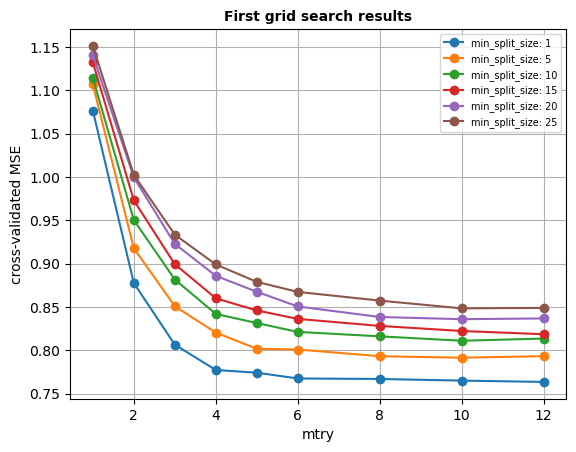

In [32]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, figsize: tuple, reverse_order: bool=False,
                     legend_loc: str="upper right", title: str="Grid search results"):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape((len(grid_param_1),len(grid_param_2)))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape((len(grid_param_1),len(grid_param_2)))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    if not reverse_order:
        # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
        for idx, val in enumerate(grid_param_2):
            ax.plot(grid_param_1, -scores_mean[:,idx], '-o', label= name_param_2 + ': ' + str(val))

        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel(name_param_1, fontsize=10)
        ax.set_ylabel('cross-validated MSE', fontsize=10)
        ax.legend(loc=legend_loc, fontsize=7)
        ax.grid('on')

    else:
        # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
        for idx, val in enumerate(grid_param_1):
            ax.plot(grid_param_2, -scores_mean[idx,:], '-o', label= name_param_1 + ': ' + str(val))

        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel(name_param_2, fontsize=10)
        ax.set_ylabel('cross-validated MSE', fontsize=10)
        ax.legend(loc=legend_loc, fontsize=7)
        ax.grid('on')


# Calling Method 
plot_grid_search(tuned_forest_1.cv_results_, param_grid_1['estimator__min_split_size'], param_grid_1['estimator__mtry'], 
                'min_split_size', 'mtry', reverse_order=True, figsize=(7,5), title='First grid search results')

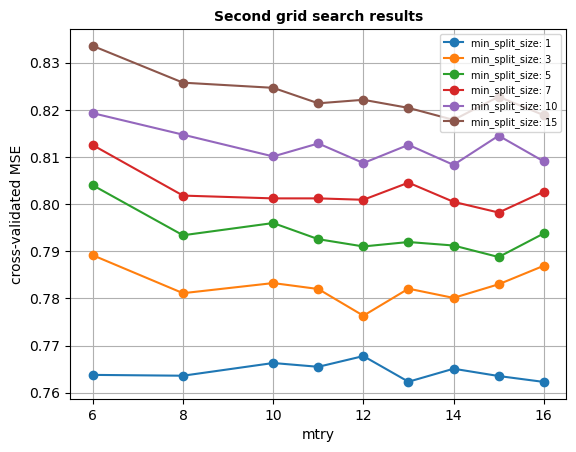

In [35]:
plot_grid_search(tuned_forest_2.cv_results_, param_grid_2['estimator__min_split_size'], param_grid_2['estimator__mtry'], 
                'min_split_size', 'mtry', reverse_order=True, figsize=(7,5), title='Second grid search results')

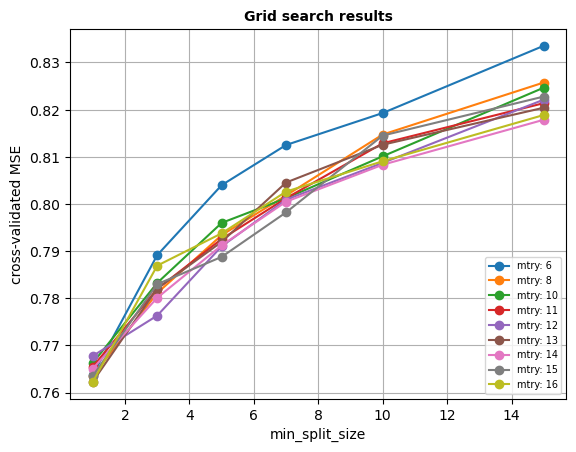

In [26]:
plot_grid_search(tuned_forest_2.cv_results_, param_grid_2['estimator__min_split_size'], param_grid_2['estimator__mtry'], 
                'min_split_size', 'mtry', reverse_order=False, figsize=(7,5), legend_loc='lower right')

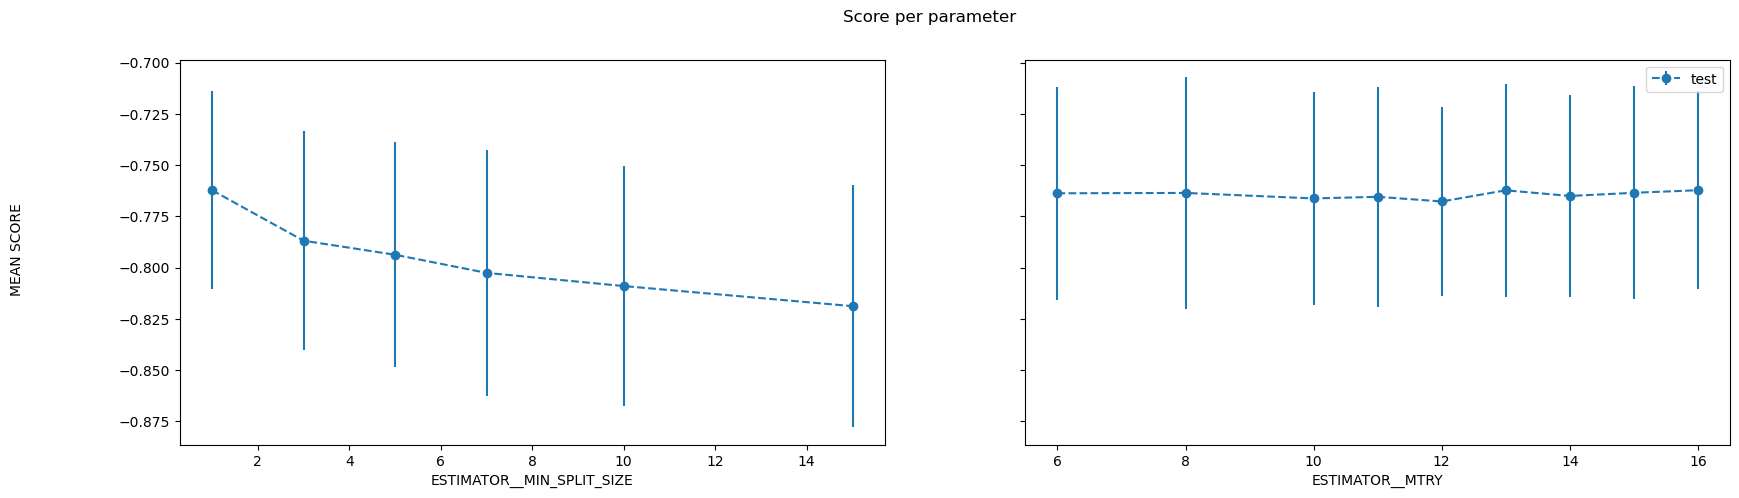

In [11]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    # means_train = results['mean_train_score']
    # stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        # y_2 = np.array(means_train[best_index])
        # e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        # ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(tuned_forest_2)

In [13]:
# tuned_forest.best_estimator_
tuned_forest_1.best_params_

{'estimator__min_split_size': 1, 'estimator__mtry': 12}

# Test the final model

In [7]:
mtry=tuned_forest_2.best_params_['estimator__mtry']
min_split_size=tuned_forest_2.best_params_['estimator__min_split_size']

In [8]:
base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=mtry,
            min_split_size=min_split_size)
forest = BaggedRegressor(estimator=base,
                         n_estimators=200,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=6,
                         verbose=1)
forest.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:  8.0min finished


BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(impurity_method='medoid', min_split_size=1,
                               mtry=16, split_type='2means'),
                n_estimators=200, n_jobs=6, verbose=1)

In [9]:
tuned_forest_1_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, tuned_forest_1_predictions)}')

tuned_forest_1_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, tuned_forest_1_fitted)}')

tuned_oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(tuned_oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(tuned_forest_1_predictions.data, y_test.data) <= Dalpha)

MSE: 0.8132690553969035
MSE: 0.6433218852582733


0.8268551236749117

In [10]:
# Retrieve the actual predictions for the network (undo the exponential mapping)
# Predictions of y_test (forest_predictions) after undoing the exponential
Y_test_stand=[logm(log_chol_to_spd(A)) for A in y_test.data]
# We also standardize the weights of the predictions to have them in the same scale
# However the computation of MSE and coverage is done in the original scale previously
Y_test_stand_pred=[logm(log_chol_to_spd(A))/logm(log_chol_to_spd(A)).max() for A in tuned_forest_1_predictions.data]
# Without scaling
Y_test_pred=[logm(log_chol_to_spd(A)) for A in tuned_forest_1_predictions.data]

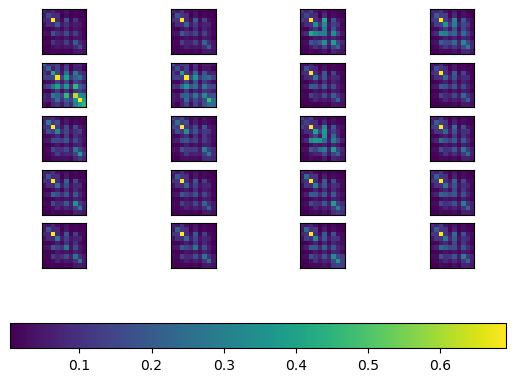

In [11]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None,
                                         cmap='viridis'):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap=cmap)
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

matrices_to_plot=[]
indices_to_plot=[1,15,21,100,105,120,150,170,250,270]
for idx in indices_to_plot:
    matrices_to_plot.append(Y_test_stand[idx])
    matrices_to_plot.append(Y_test_pred[idx])
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(5,4))

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Example coordinates of locations in Manhattan (latitude, longitude)
locations = {
    1: (40.824332, -73.938081),  # Central Harlem North
    2: (40.803865, -73.965072),  # Manhattan Valley
    3: (40.779041, -73.947275),  # Yorkville
    4: (40.765389, -73.997188),  # Hudson Yards/Hell's Kitchen
    5: (40.749146, -73.999223),  # Penn Station, 9th Avenue
    6: (40.757393, -73.986048),  # Midtown (Times Square)
    7: (40.737396, -73.992640),  # Union Square/Flatiron
    8: (40.736674, -73.978193),  # Peter Cooper Village
    9: (40.711605, -74.013119),  # World Trade Center
    10: (40.720083, -73.979447)  # Alphabet City
}


In [13]:
def draw_manhattan(ax, graph: nx.Graph, resolution: str='h', scale_weight: float=3, plot_node_label: bool=True):
    m = Basemap(projection='merc',
            llcrnrlat=40.695533, urcrnrlat=40.84,
            llcrnrlon=-74.043468, urcrnrlon=-73.917852,
            resolution=resolution, ax=ax) # c (crude) < l (low) < i (intermediate) < h (high) < f (full)

    # Draw map details
    m.drawcoastlines()
    m.drawcountries()
    # m.drawstates()
    m.drawrivers()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')

    # Project coordinates to the map
    mapped_locations = {node: m(lon, lat) for node, (lat, lon) in locations.items()}

    # Draw the nodes
    for node, (x, y) in mapped_locations.items():
        m.plot(x, y, 'o', markersize=5, color='red')
        if plot_node_label:
            ax.text(x, y, f'{node}', fontsize=10, ha='right', va='bottom')

    # Draw the edges with weights
    max_weight=max(graph[u][v]['weight'] for u, v in graph.edges)
    normalized_weights = {(i,j): weight / max_weight for i, j, weight in graph.edges(data='weight')}
    for i, j, weight in graph.edges(data='weight'):
        x1, y1 = mapped_locations[i+1]
        x2, y2 = mapped_locations[j+1]
        m.plot([x1, x2], [y1, y2], 'k-', lw=scale_weight*(normalized_weights[(i,j)]))  # Use weight for line width

In [45]:
G_pred=nx.from_numpy_array(Y_test_stand_pred[2])
max(G_pred[u][v]['weight'] for u, v in G_pred.edges)

1.0

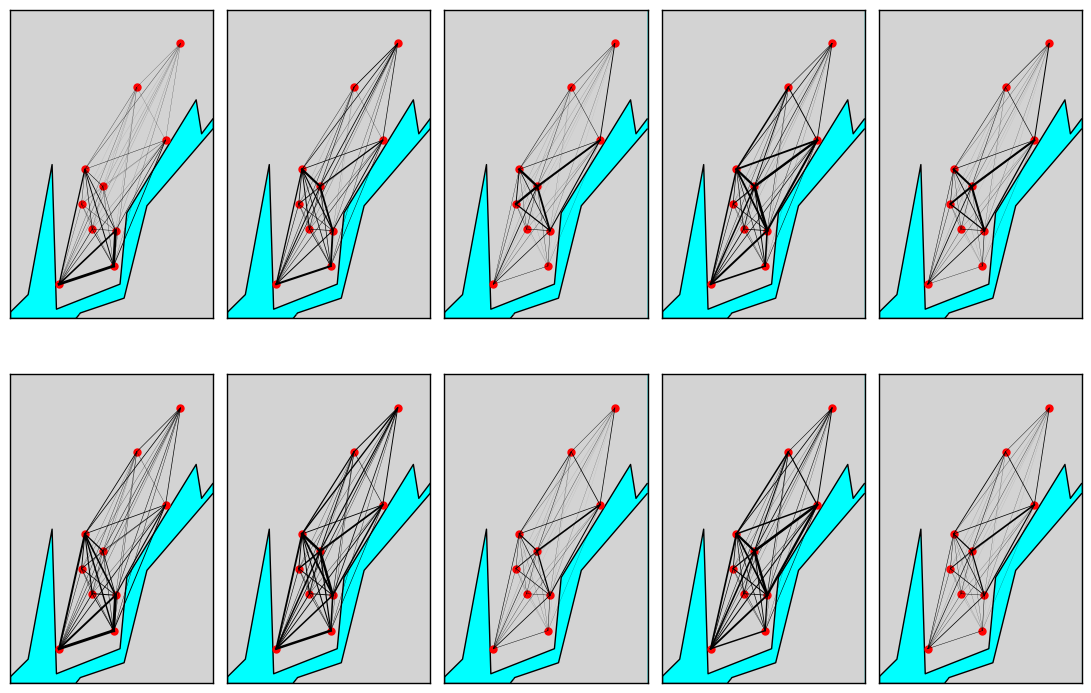

In [82]:
# Some interesting cases: 7, 102, 155, 170, 202, 245, 281
matrices_to_plot=[7,102,62,245,155]
fig, axs=plt.subplots(2, len(matrices_to_plot), figsize=(11,8))

j=0
for idx in matrices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand[idx])
    draw_manhattan(axs[0,j], graph=G_true, resolution='i', plot_node_label=False)
    G_pred=nx.from_numpy_array(Y_test_pred[idx])
    draw_manhattan(axs[1,j], graph=G_pred, resolution='i', plot_node_label=False)
    j+=1

# plt.suptitle("Network Graphs", fontsize=10)
plt.tight_layout(pad=1.01)
# plt.subplots_adjust(top=0.95)
plt.show()

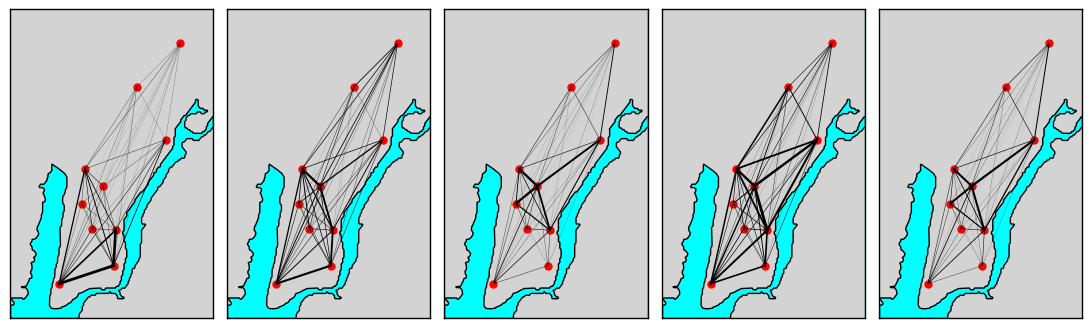

In [84]:
matrices_to_plot=[7,102,62,245,155]
fig, axs=plt.subplots(1, len(matrices_to_plot), figsize=(11,8))

# Plot only the true values
j=0
for idx in matrices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand[idx])
    draw_manhattan(axs[j], graph=G_true, resolution='f', plot_node_label=False)
    # G_pred=nx.from_numpy_array(Y_test_pred[idx])
    # draw_manhattan(axs[1,j], graph=G_pred, resolution='i', plot_node_label=False)
    j+=1

# plt.suptitle("Network Graphs", fontsize=10)
plt.tight_layout(pad=1.01)
# plt.subplots_adjust(top=0.95)
plt.show()

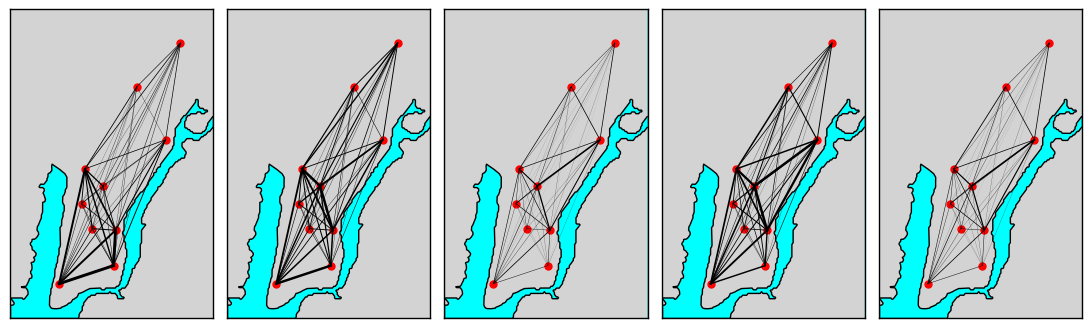

In [86]:
matrices_to_plot=[7,102,62,245,155]
fig, axs=plt.subplots(1, len(matrices_to_plot), figsize=(11,8))

# Plot only the predictions
j=0
for idx in matrices_to_plot:
    # G_true=nx.from_numpy_array(Y_test_stand[idx])
    # draw_manhattan(axs[j], graph=G_true, resolution='i', plot_node_label=False)
    G_pred=nx.from_numpy_array(Y_test_pred[idx])
    draw_manhattan(axs[j], graph=G_pred, resolution='f', plot_node_label=False)
    j+=1

# plt.suptitle("Network Graphs", fontsize=10)
plt.tight_layout(pad=1.01)
# plt.subplots_adjust(top=0.95)
plt.show()

In [91]:
# The standardization is not preserved in the predictions
maximum_entries_preds=[]
for A in Y_test_pred:
    maximum_entries_preds.append(A.max())

pd.Series(maximum_entries_preds).describe()

count    283.000000
mean       0.658514
std        0.043443
min        0.519816
25%        0.639468
50%        0.673590
75%        0.687434
max        0.716619
dtype: float64

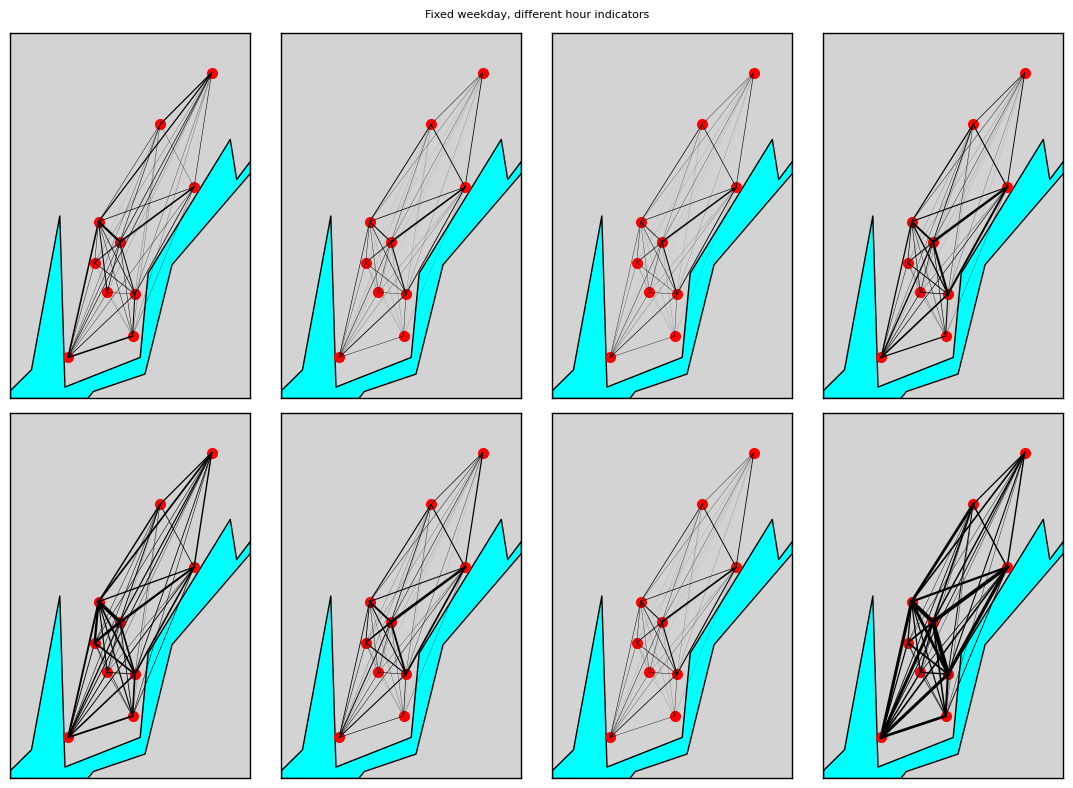

In [74]:
# 11, 15, 16, 14, 10, 12, 13 columns  correspond to Monday, Tuesday, ..., Sunday
# 7 is the late night column
# 8 is the middays column
# 9 is the Rush hour column
# 6 is the evening column
# X_test[(X_test[:,7]==1) & (X_test[:,11]==1) ][0] # Monday and late night
# X_test[(X_test[:,9]==1) & (X_test[:,11]==1) ][0] # Monday and Rush hour
# X_test[(X_test[:,8]==1) & (X_test[:,11]==1) ][0] # Monday and middays
# X_test[(X_test[:,6]==1) & (X_test[:,11]==1) ][0] # Monday and evening


matrices_to_plot=[np.where(np.all(X_test==X_test[(X_test[:,7]==1) & (X_test[:,11]==1) ][0], axis=1 ))[0][0],
                np.where(np.all(X_test==X_test[(X_test[:,9]==1) & (X_test[:,11]==1) ][0], axis=1 ))[0][0],
                np.where(np.all(X_test==X_test[(X_test[:,8]==1) & (X_test[:,11]==1) ][0], axis=1 ))[0][0],
                np.where(np.all(X_test==X_test[(X_test[:,6]==1) & (X_test[:,11]==1) ][0], axis=1 ))[0][0]]

fig, axs=plt.subplots(2, len(matrices_to_plot), figsize=(11,8))

j=0
for idx in matrices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand[idx])
    draw_manhattan(axs[0,j], graph=G_true, resolution='i', plot_node_label=False)
    G_pred=nx.from_numpy_array(Y_test_stand_pred[idx])
    draw_manhattan(axs[1,j], graph=G_pred, resolution='i', plot_node_label=False)
    j+=1

plt.suptitle("Fixed weekday, different hour indicators", fontsize=8)
plt.tight_layout()
# plt.subplots_adjust(top=0.95)
plt.show()


### Predictions for all the days of one week (21-27 january) in Rush hour

In [40]:
full_week=pd.concat([df[ (df['Day']==21) & (df['hour_interval_lower']==datetime(2019, 1, 21, 7)) ].iloc[0:24],
                     df[ (df['Day']==22) & (df['hour_interval_lower']==datetime(2019, 1, 22, 7)) ].iloc[0:24],
                     df[ (df['Day']==23) & (df['hour_interval_lower']==datetime(2019, 1, 23, 7)) ].iloc[0:24],
                     df[ (df['Day']==24) & (df['hour_interval_lower']==datetime(2019, 1, 24, 7)) ].iloc[0:24],
                     df[ (df['Day']==25) & (df['hour_interval_lower']==datetime(2019, 1, 25, 7)) ].iloc[0:24],
                     df[ (df['Day']==26) & (df['hour_interval_lower']==datetime(2019, 1, 26, 7)) ].iloc[0:24],
                     df[ (df['Day']==27) & (df['hour_interval_lower']==datetime(2019, 1, 27, 7)) ].iloc[0:24],
                     df], axis=0, ignore_index=False)
Y_stand_full_week=[Y[idx]/Y[idx].max() for idx in range(len(Y)) if idx in list(full_week.index)] # Standardize the weights
Y_ExpLogChol_full_week=np.c_[[spd_to_log_chol(expm(A)) for A in Y_stand_full_week]]
Y_stand_full_week=MetricData(M, Y_ExpLogChol_full_week)

full_week=full_week[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
          'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday']]
X_full_week=pd.get_dummies(data=full_week, columns=['Hour.Indicator', 'Weekday'])

full_week_pred=forest.predict(X_full_week.iloc[0:7])



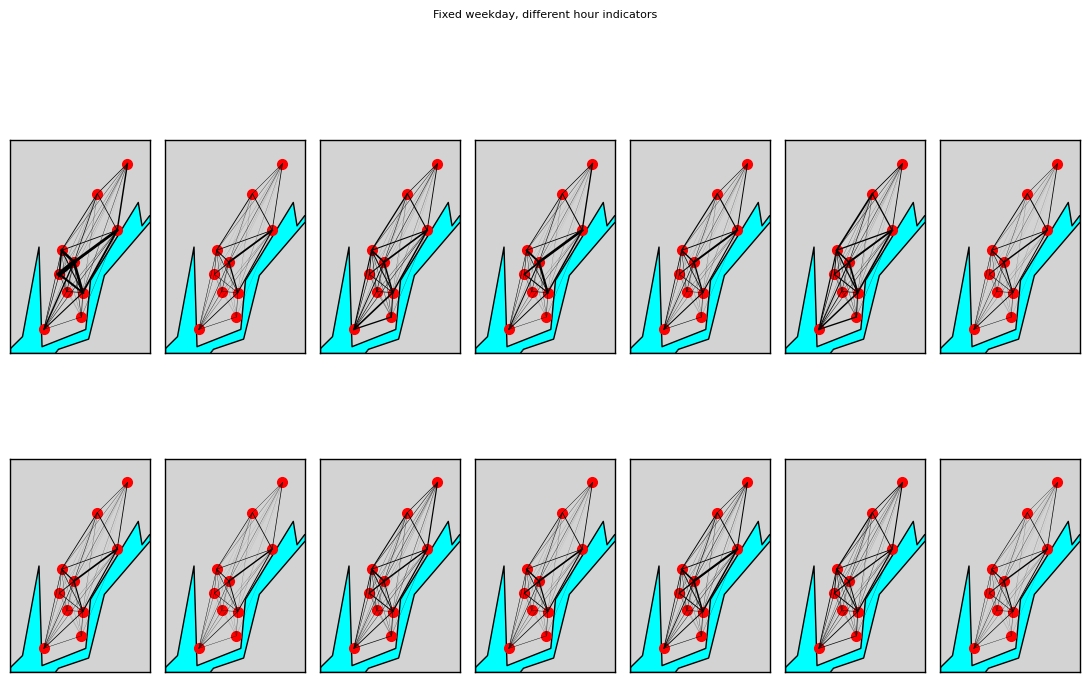

In [183]:
indices_to_plot=range(7)

fig, axs=plt.subplots(2, len(matrices_to_plot), figsize=(11,8))

j=0
for idx in indices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand[idx])
    draw_manhattan(axs[0,j], graph=G_true, resolution='i', plot_node_label=False)
    G_pred=nx.from_numpy_array(Y_test_stand_pred[idx])
    draw_manhattan(axs[1,j], graph=G_pred, resolution='i', plot_node_label=False)
    j+=1

plt.suptitle("Seven days of the same week in January in Rush Hour", fontsize=8)
plt.tight_layout()
# plt.subplots_adjust(top=0.95)
plt.show()

### Predictions for all the days of one week (21-27 february) in Middays

In [41]:
full_week=pd.concat([df[ (df['Day']==21) & (df['hour_interval_lower']==datetime(2019, 2, 21, 11)) ].iloc[0:24],
                     df[ (df['Day']==22) & (df['hour_interval_lower']==datetime(2019, 2, 22, 11)) ].iloc[0:24],
                     df[ (df['Day']==23) & (df['hour_interval_lower']==datetime(2019, 2, 23, 11)) ].iloc[0:24],
                     df[ (df['Day']==24) & (df['hour_interval_lower']==datetime(2019, 2, 24, 11)) ].iloc[0:24],
                     df[ (df['Day']==25) & (df['hour_interval_lower']==datetime(2019, 2, 25, 11)) ].iloc[0:24],
                     df[ (df['Day']==26) & (df['hour_interval_lower']==datetime(2019, 2, 26, 11)) ].iloc[0:24],
                     df[ (df['Day']==27) & (df['hour_interval_lower']==datetime(2019, 2, 27, 11)) ].iloc[0:24],
                     df], axis=0, ignore_index=False)
Y_stand_full_week=[Y[idx]/Y[idx].max() for idx in range(len(Y)) if idx in list(full_week.index)] # Standardize the weights
Y_ExpLogChol_full_week=np.c_[[spd_to_log_chol(expm(A)) for A in Y_stand_full_week]]
Y_stand_full_week=MetricData(M, Y_ExpLogChol_full_week)

full_week=full_week[['Temp.Avg', 'DewPoint.Avg', 'Humidity.Avg', 'WindSpeed.Avg', 
          'Pressure.Avg', 'Precipitation', 'Hour.Indicator', 'Weekday']]
X_full_week=pd.get_dummies(data=full_week, columns=['Hour.Indicator', 'Weekday'])

full_week_pred=forest.predict(X_full_week.iloc[0:7])

Y_test_stand_full_week=[logm(log_chol_to_spd(A)) for A in Y_stand_full_week]
Y_test_stand_pred_full_week=[logm(log_chol_to_spd(A)) for A in full_week_pred.data]

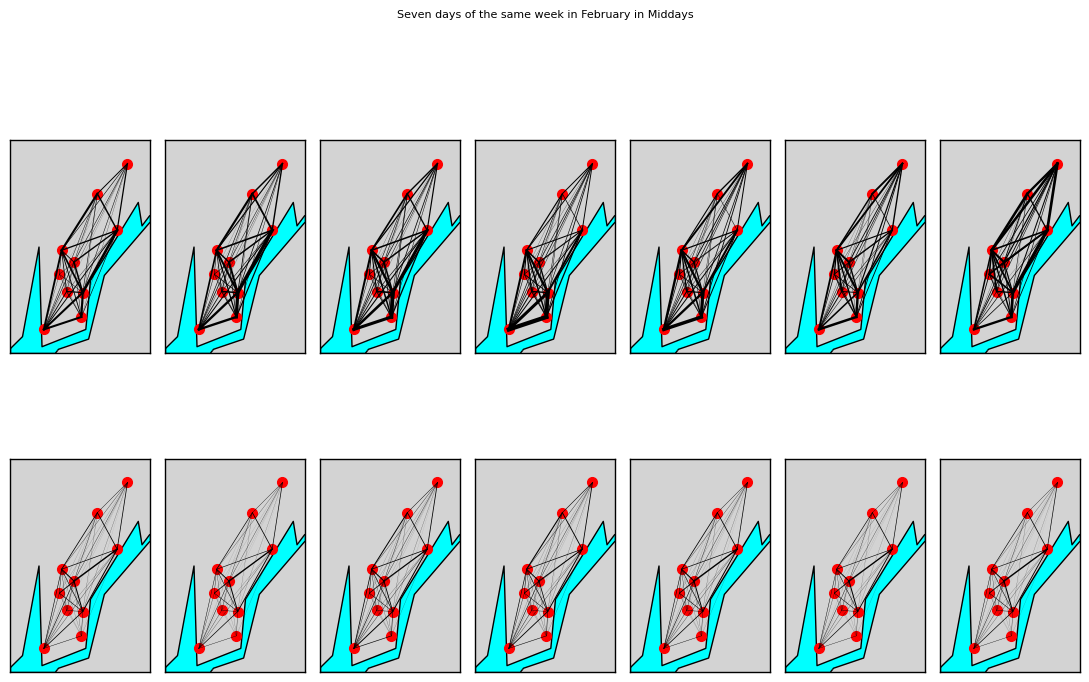

In [43]:
indices_to_plot=range(7)

fig, axs=plt.subplots(2, len(matrices_to_plot), figsize=(11,8))

j=0
for idx in indices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand_full_week[idx])
    draw_manhattan(axs[0,j], graph=G_true, resolution='i', plot_node_label=False)
    G_pred=nx.from_numpy_array(Y_test_stand_pred_full_week[idx])
    draw_manhattan(axs[1,j], graph=G_pred, resolution='i', plot_node_label=False)
    j+=1

plt.suptitle("Seven days of the same week in February in Middays", fontsize=8)
plt.tight_layout()
# plt.subplots_adjust(top=0.95)
plt.show()

# Plots of OOB Balls

In [49]:
def draw_manhattan(ax, graph: nx.Graph, 
                   resolution: str='i', 
                   scale_weight: float=3, 
                   plot_node_label: bool=True,
                   alpha: float=0.1,
                   edge_color='deepskyblue',
                   return_map: bool=False):
    m = Basemap(projection='merc',
            llcrnrlat=40.695533, urcrnrlat=40.84,
            llcrnrlon=-74.043468, urcrnrlon=-73.917852,
            resolution=resolution, ax=ax) # c (crude) < l (low) < i (intermediate) < h (high) < f (full)

    # Draw map details
    m.drawcoastlines()
    m.drawcountries()
    # m.drawstates()
    m.drawrivers()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')

    # Project coordinates to the map
    mapped_locations = {node: m(lon, lat) for node, (lat, lon) in locations.items()}

    # Draw the nodes
    for node, (x, y) in mapped_locations.items():
        m.plot(x, y, 'o', markersize=5, color='red')
        if plot_node_label:
            ax.text(x, y, f'{node}', fontsize=10, ha='right', va='bottom')

    # Draw the edges with weights
    max_weight=max(graph[u][v]['weight'] for u, v in graph.edges)
    normalized_weights = {(i,j): weight / max_weight for i, j, weight in graph.edges(data='weight')}
    for i, j, weight in graph.edges(data='weight'):
        x1, y1 = mapped_locations[i+1]
        x2, y2 = mapped_locations[j+1]
        m.plot([x1, x2], [y1, y2], color=edge_color, 
               lw=scale_weight*(normalized_weights[(i,j)]),
               linestyle='-',
               alpha=alpha)  # Use weight for line width
        
    if return_map:
        return m

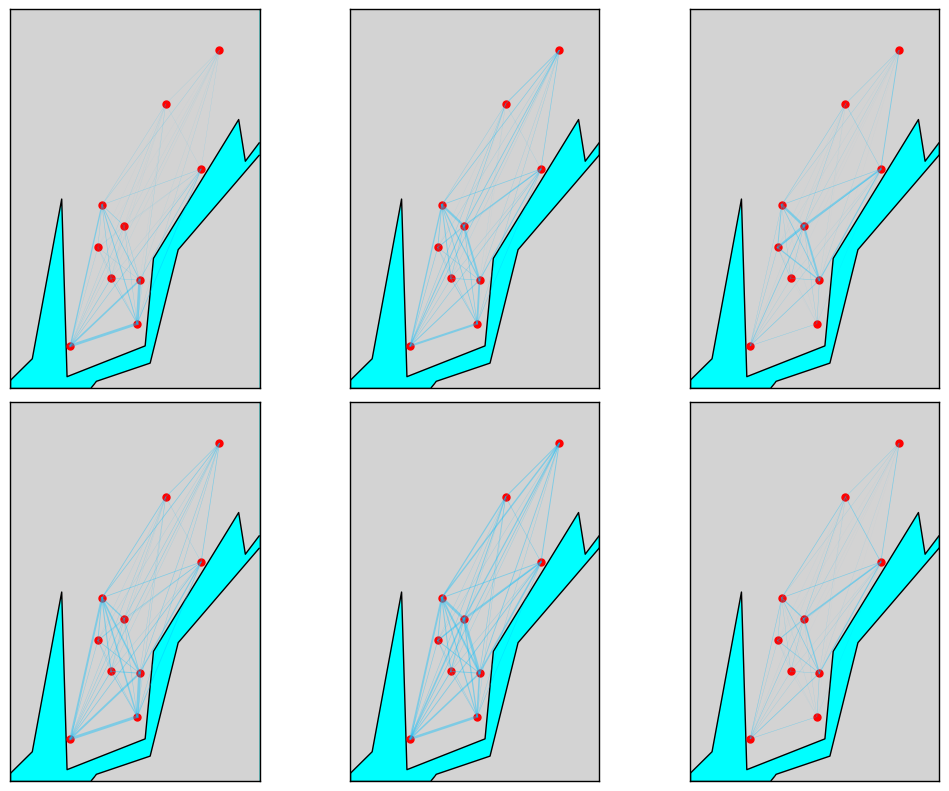

In [22]:
# Testing the transparency
matrices_to_plot=[7,102,62]
fig, axs=plt.subplots(2, len(matrices_to_plot), figsize=(11,8))

j=0
for idx in matrices_to_plot:
    G_true=nx.from_numpy_array(Y_test_stand[idx])
    draw_manhattan(axs[0,j], graph=G_true, resolution='i', 
                   plot_node_label=False,
                   alpha=0.4)
    G_pred=nx.from_numpy_array(Y_test_pred[idx])
    draw_manhattan(axs[1,j], graph=G_pred, resolution='i', 
                   plot_node_label=False,
                   alpha=0.4)
    j+=1

# plt.suptitle("Network Graphs", fontsize=10)
plt.tight_layout(pad=1.01)
# plt.subplots_adjust(top=0.95)
plt.show()

In [176]:
def plot_OOB_balls_manhattan(predictions: np.ndarray,
                        indices_to_plot: list[int],
                        Dalpha: float,
                        ax,
                        resolution: str='i',
                        reference: Union[np.ndarray, None]=None,
                        # df: int=2,
                        MC_samples: int=100,
                        edge_color='deepskyblue',
                        alpha: float=0.1) -> None:

    
    for index_to_plot in indices_to_plot:

        # sample=wishart(df=df, scale=(1/df)*expm(predictions[index_to_plot])).rvs(size=MC_samples)
        # sample=[spd_to_log_chol(logm(A)) for A in sample]
        # sample=[predictions[index_to_plot]+np.random.normal(scale=0.1, size=100).reshape(10,10)  for _ in range(MC_samples)]
        m=draw_manhattan(ax=ax,
                        graph=nx.from_numpy_array(predictions[index_to_plot]),
                        resolution=resolution,
                        plot_node_label=False,
                        return_map=True,
                        edge_color='black',
                        alpha=0)
        mapped_locations={node: m(lon, lat) for node, (lat, lon) in locations.items()}
        count=0
        for A in reference:
            if count<MC_samples:
                if M.d(spd_to_log_chol(expm(A)), 
                        spd_to_log_chol(expm(predictions[index_to_plot])))<=Dalpha:
                    
                    graph=nx.from_numpy_array(A)
                    max_weight=max(graph[u][v]['weight'] for u, v in graph.edges)
                    normalized_weights = {(i,j): weight / max_weight for i, j, weight in graph.edges(data='weight')}
                    for i, j, _ in graph.edges(data='weight'):
                        x1, y1 = mapped_locations[i+1]
                        x2, y2 = mapped_locations[j+1]
                        m.plot([x1, x2], [y1, y2], color=edge_color, 
                            lw=3*normalized_weights[(i,j)],
                            linestyle='-',
                            alpha=alpha)
                        
                    count+=1
            else:
                break



In [178]:
alpha=0.05
Dalpha=np.percentile(tuned_oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(tuned_forest_1_predictions.data, y_test.data) <= Dalpha))

idx=7
fig, ax=plt.subplots(1, 2, figsize=(8, 10))
G_true=nx.from_numpy_array(Y_test_stand[idx])
draw_manhattan(ax=ax[0], graph=G_true, resolution='i', plot_node_label=False, alpha=1, edge_color='black')
plot_OOB_balls_manhattan(predictions=Y_test_pred, 
                         reference=Y_test_stand, indices_to_plot=[idx],
                         Dalpha=Dalpha, alpha=0.05, ax=ax[1], MC_samples=25)

plt.show()

0.8268551236749117


In [106]:
Dalpha

1.2199780292243392

In [35]:
np.linalg.eigvals((1/10)*expm(Y_test_pred[20]))

array([0.31642955, 0.15434531, 0.12995325, 0.09033398, 0.11704325,
       0.11134435, 0.10551091, 0.10258901, 0.09984003, 0.10078324])

In [42]:
sample=wishart(df=10, scale=(1/10)*expm(Y_test_pred[20])).rvs(size=50)
prueba=[logm(A) for A in sample]

In [43]:
np.linalg.eigvals(prueba[0])

array([-5.80283055, -4.24852892, -2.15112801, -1.15242026, -0.81847346,
       -0.03219002,  1.10522966,  0.60465942,  0.83044609,  0.75413439])

# Some checkings

In [27]:
Y_stand_exp=[expm(A) for A in Y_stand]
eigvals=np.zeros((10, len(Y_stand_exp)))
for j in range(len(Y_stand_exp)):
    eigvals[:,j]=np.linalg.eigvals(Y_stand_exp[j])


In [28]:
pd.DataFrame([eigvals[:,j] for j in range(eigvals.shape[1])]).describe()

,0,1,2,3,4,5,6,7,8,9
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,6.654128,2.104520,1.610573,1.307536,1.195830,1.083570,1.049986,1.040635,1.029814,1.028251
std,3.875722,0.287533,0.252816,0.233375,0.138379,0.117098,0.086662,0.068188,0.060182,0.061010
min,3.149417,1.514041,0.505301,0.520590,0.644555,0.710323,0.799585,0.813235,0.856879,0.834214
25%,3.887792,1.882994,1.454331,1.246497,1.164266,0.967059,0.972654,0.997654,0.998206,0.997686
50%,4.921862,2.057232,1.582368,1.310671,1.203675,1.092935,1.062452,1.041228,1.018826,1.012170
75%,8.370587,2.278345,1.748495,1.419205,1.253000,1.159069,1.092890,1.063401,1.042460,1.037573
max,28.397884,3.208305,2.381611,2.572586,1.776695,1.653012,1.599696,1.482622,1.396313,1.451289


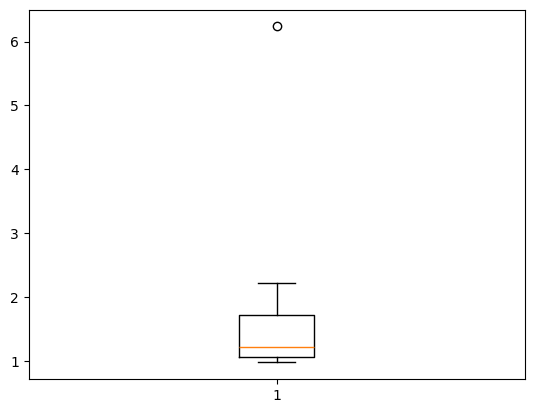

In [30]:
plt.figure()
plt.boxplot(eigvals[:,0])
plt.show()